In [5]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
from datetime import datetime
from geopy.distance import geodesic

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define the folder path
folder_path = '/content/drive/MyDrive/marathon pacing/'

# Step 3: List all GPX files in the folder
gpx_files = [f for f in os.listdir(folder_path) if f.endswith('.gpx')]

# Step 4: Function to parse a GPX file
def parse_gpx(file_path, filename):
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Namespace to handle XML parsing
    namespace = {'ns': 'http://www.topografix.com/GPX/1/1'}

    # Clean the filename to the desired format (e.g., Danang_Marathon_2023 -> Danang Marathon 2023)
    clean_filename = filename.replace('_', ' ').replace('.gpx', '')

    # Extract data: Assuming we're interested in trackpoints (lat, lon, time, elevation)
    data = []
    for trkpt in root.findall('.//ns:trkpt', namespace):
        lat = float(trkpt.attrib['lat'])
        lon = float(trkpt.attrib['lon'])
        time = trkpt.find('ns:time', namespace).text
        ele = float(trkpt.find('ns:ele', namespace).text) if trkpt.find('ns:ele', namespace) is not None else None
        # Add the cleaned filename to each row
        data.append([lat, lon, time, ele, clean_filename])

    return data

# Step 5: Read all GPX files and combine into one DataFrame
all_data = []

for gpx_file in gpx_files:
    file_path = os.path.join(folder_path, gpx_file)
    gpx_data = parse_gpx(file_path, gpx_file)  # Pass the filename here
    all_data.extend(gpx_data)

# Step 6: Convert to DataFrame and include cleaned filename
df = pd.DataFrame(all_data, columns=['Latitude', 'Longitude', 'Time', 'Elevation', 'Filename'])

# Step 7: Convert 'Time' to datetime and extract date in dd-mm-yyyy format
df['Time'] = pd.to_datetime(df['Time'])
df['Date'] = df['Time'].dt.strftime('%d-%m-%Y')

# Step 8: Function to calculate pace between two points
def calculate_pace(row1, row2):
    # Calculate the distance between two consecutive points (in kilometers)
    coords_1 = (row1['Latitude'], row1['Longitude'])
    coords_2 = (row2['Latitude'], row2['Longitude'])
    distance = geodesic(coords_1, coords_2).km

    # Calculate time difference in seconds
    time_diff = (row2['Time'] - row1['Time']).total_seconds()

    # Calculate pace: time per kilometer in minutes per km (time_diff / distance / 60)
    pace = (time_diff / distance) / 60 if distance > 0 else None
    return pace

# Step 9: Function to calculate cumulative distance for each group
def calculate_cumulative_distance(group_df):
    distances = [0]  # The first row has no distance (no previous point to compare to)

    for i in range(1, len(group_df)):
        # Calculate the distance between consecutive points
        coords_1 = (group_df.iloc[i-1]['Latitude'], group_df.iloc[i-1]['Longitude'])
        coords_2 = (group_df.iloc[i]['Latitude'], group_df.iloc[i]['Longitude'])
        distance = geodesic(coords_1, coords_2).km

        # Accumulate the distance
        cumulative_distance = distances[-1] + distance
        distances.append(cumulative_distance)

    group_df['Cumulative Distance (km)'] = distances
    return group_df

# Step 10: Add 'Pace (min/km)' and 'Cumulative Distance' per filename
def calculate_pace_and_distance_for_group(group_df):
    paces = [None]  # The first row has no pace (no previous point to compare to)

    for i in range(1, len(group_df)):
        pace = calculate_pace(group_df.iloc[i-1], group_df.iloc[i])
        paces.append(pace)

    group_df['Pace (min/km)'] = paces
    group_df = calculate_cumulative_distance(group_df)  # Add cumulative distance column
    return group_df

# Step 11: Apply pace and cumulative distance calculation to each group of Filename
df = df.groupby('Filename').apply(calculate_pace_and_distance_for_group)

# Step 12: Display the DataFrame
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-1752924947.py:99: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Filename').apply(calculate_pace_and_distance_for_group)


Latitude  Longitude                      Time  \
Filename                                                                
Berlin Marathon 69786  52.515220  13.360417 2022-09-25 08:30:30+00:00   
                69787  52.515222  13.360390 2022-09-25 08:30:31+00:00   
                69788  52.515222  13.360355 2022-09-25 08:30:32+00:00   
                69789  52.515213  13.360313 2022-09-25 08:30:33+00:00   
                69790  52.515208  13.360278 2022-09-25 08:30:34+00:00   

                       Elevation         Filename        Date  Pace (min/km)  \
Filename                                                                       
Berlin Marathon 69786       37.6  Berlin Marathon  25-09-2022            NaN   
                69787       37.6  Berlin Marathon  25-09-2022       9.026551   
                69788       37.6  Berlin Marathon  25-09-2022       7.014481   
                69789       37.6  Berlin Marathon  25-09-2022       5.515080   
                69790       37.6  Berlin Marathon  25-09-2022       6.829729   

                       Cumulative Distance (km)  
Filename                                         
Berlin Marathon 69786                  0.000000  
                69787                  0.001846  
                69788                  0.004222  
                69789                  0.007244  
                69790                  0.009685

In [15]:
# Function to calculate average pace in intervals (e.g., 1km)
def calculate_average_pace_in_intervals(group_df, interval_km=1):
    interval_data = []
    # Iterate through the cumulative distance in steps of the defined interval
    for i in range(0, int(group_df['Cumulative Distance (km)'].max()) + interval_km, interval_km):
        # Define the start and end of the interval
        start_km = i
        end_km = i + interval_km

        # Filter data within the current interval
        interval_df = group_df[(group_df['Cumulative Distance (km)'] >= start_km) & (group_df['Cumulative Distance (km)'] < end_km)]

        # Calculate the average pace for the interval, if there's data
        if not interval_df.empty:
            average_pace = interval_df['Pace (min/km)'].mean()
            interval_data.append([group_df['Filename'].iloc[0], start_km, end_km, average_pace])

    return interval_data

# Apply the function to each filename group and combine results
all_interval_data = []
# Reset the index before grouping to avoid the ambiguity error, dropping the 'Filename' index level
df_filtered_reset = df_filtered.reset_index(level='Filename', drop=True)
for filename, group_df in df_filtered_reset.groupby('Filename'):
    interval_data = calculate_average_pace_in_intervals(group_df)
    all_interval_data.extend(interval_data)

# Create a new DataFrame with the interval data
df_interval_pace = pd.DataFrame(all_interval_data, columns=['Filename', 'Start KM', 'End KM', 'Average Pace (min/km)'])

# Display the new DataFrame
display(df_interval_pace.head())

,Filename,Start KM,End KM,Average Pace (min/km)
0,Berlin Marathon,0,1,4.968684
1,Berlin Marathon,1,2,4.528034
2,Berlin Marathon,2,3,4.226868
3,Berlin Marathon,3,4,4.777301
4,Berlin Marathon,4,5,4.496892


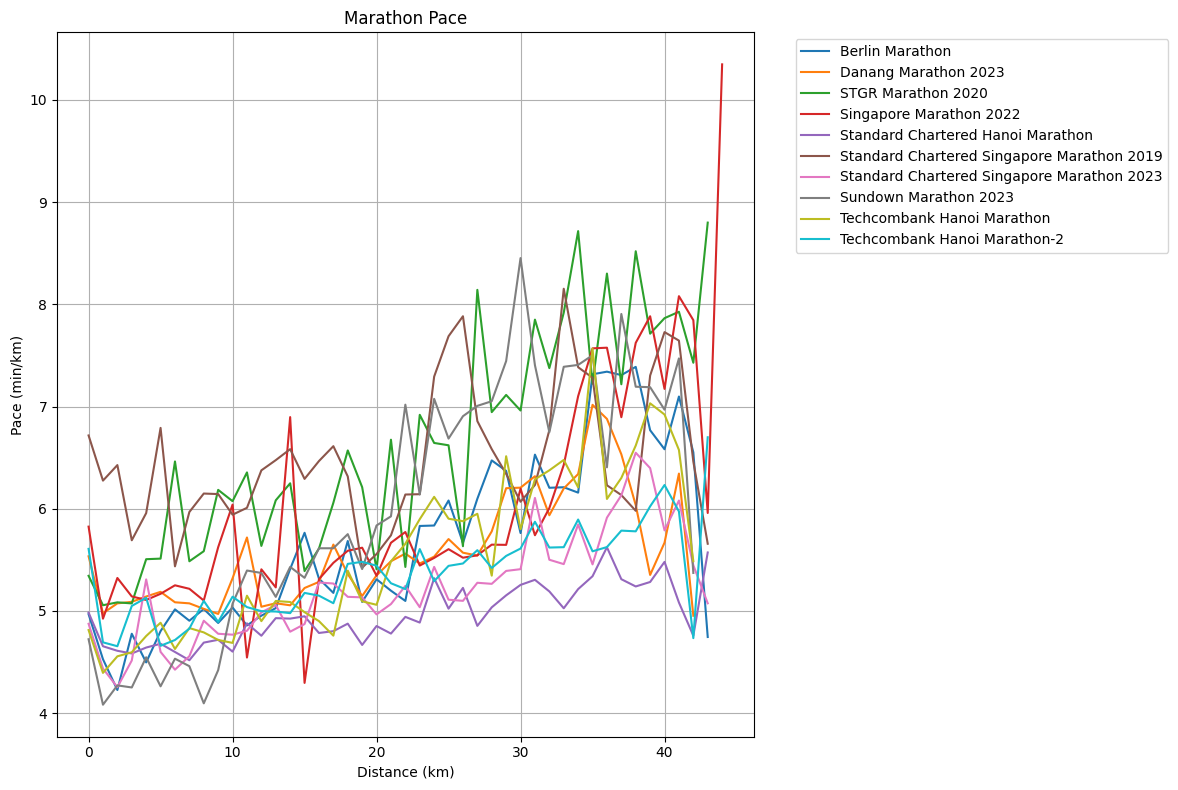

In [18]:
# Plotting average pace over distance intervals
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_interval_pace, x='Start KM', y='Average Pace (min/km)', hue='Filename')
plt.title('Marathon Pace')
plt.xlabel('Distance (km)')
plt.ylabel('Pace (min/km)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Task
Analyze and visualize the pace of different marathons by performing a linear fit on the average pace per kilometer data and plotting the original data along with the fitted lines. Add a vertical line at 21km to indicate the half-marathon point.

## Prepare data for linear fit

### Subtask:
Select the 'Start KM' and 'Average Pace (min/km)' columns from `df_interval_pace`.


**Reasoning**:
Select the required columns from df_interval_pace to prepare data for linear regression.



In [19]:
df_for_regression = df_interval_pace[['Start KM', 'Average Pace (min/km)']]

## Perform linear regression for each marathon

### Subtask:
Iterate through each unique filename, fit a linear model to the pace and distance data for that marathon, and store the model parameters (slope and intercept).


**Reasoning**:
Iterate through each unique filename, fit a linear model to the pace and distance data for that marathon, and store the model parameters (slope and intercept).



In [20]:
from sklearn.linear_model import LinearRegression

regression_results = []

for filename in df_interval_pace['Filename'].unique():
    marathon_df = df_interval_pace[df_interval_pace['Filename'] == filename]

    X = marathon_df['Start KM'].values.reshape(-1, 1)
    y = marathon_df['Average Pace (min/km)'].values

    model = LinearRegression()
    model.fit(X, y)

    intercept = model.intercept_
    coefficient = model.coef_[0]

    regression_results.append({
        'Filename': filename,
        'Intercept': intercept,
        'Coefficient': coefficient
    })

df_regression_results = pd.DataFrame(regression_results)
display(df_regression_results)

,Filename,Intercept,Coefficient
0,Berlin Marathon,4.474470,0.056006
1,Danang Marathon 2023,4.959786,0.029599
2,STGR Marathon 2020,5.046056,0.072771
3,Singapore Marathon 2022,4.624734,0.063746
4,Standard Chartered Hanoi Marathon,4.586635,0.017757
5,Standard Chartered Singapore Marathon 2019,6.044309,0.020451
6,Standard Chartered Singapore Marathon 2023,4.501221,0.033568
7,Sundown Marathon 2023,4.225422,0.084796
8,Techcombank Hanoi Marathon,4.370375,0.056096
9,Techcombank Hanoi Marathon-2,4.797325,0.026515


## Generate fitted values

### Subtask:
Use the fitted linear models to calculate predicted pace values across the distance range for each marathon.


**Reasoning**:
Calculate the predicted pace for each marathon using the fitted linear models and store the results in a new DataFrame.



In [21]:
all_fitted_data = []

for index, row in df_regression_results.iterrows():
    filename = row['Filename']
    intercept = row['Intercept']
    coefficient = row['Coefficient']

    marathon_df = df_interval_pace[df_interval_pace['Filename'] == filename]
    start_kms = marathon_df['Start KM'].values

    predicted_pace = intercept + coefficient * start_kms

    temp_df = pd.DataFrame({
        'Filename': filename,
        'Start KM': start_kms,
        'Predicted Pace': predicted_pace
    })
    all_fitted_data.append(temp_df)

df_fitted_pace = pd.concat(all_fitted_data, ignore_index=True)
display(df_fitted_pace.head())

,Filename,Start KM,Predicted Pace
0,Berlin Marathon,0,4.474470
1,Berlin Marathon,1,4.530476
2,Berlin Marathon,2,4.586482
3,Berlin Marathon,3,4.642489
4,Berlin Marathon,4,4.698495


## Combine original and fitted data

### Subtask:
Create a new DataFrame that includes the original average pace data and the calculated fitted pace values, along with the filename and distance.


**Reasoning**:
Select the necessary columns from df_interval_pace and merge with df_fitted_pace to create the combined dataframe.



In [22]:
df_original_pace = df_interval_pace[['Filename', 'Start KM', 'Average Pace (min/km)']]
df_combined_pace = pd.merge(df_original_pace, df_fitted_pace, on=['Filename', 'Start KM'])
display(df_combined_pace.head())

,Filename,Start KM,Average Pace (min/km),Predicted Pace
0,Berlin Marathon,0,4.968684,4.474470
1,Berlin Marathon,1,4.528034,4.530476
2,Berlin Marathon,2,4.226868,4.586482
3,Berlin Marathon,3,4.777301,4.642489
4,Berlin Marathon,4,4.496892,4.698495


## Plot original data and linear fits

### Subtask:
Use seaborn to plot the original average pace data as points and the fitted linear models as lines on the same plot.


**Reasoning**:
Use seaborn to create a scatter plot of the original average pace and a line plot of the predicted pace on the same figure, differentiating marathons by color.



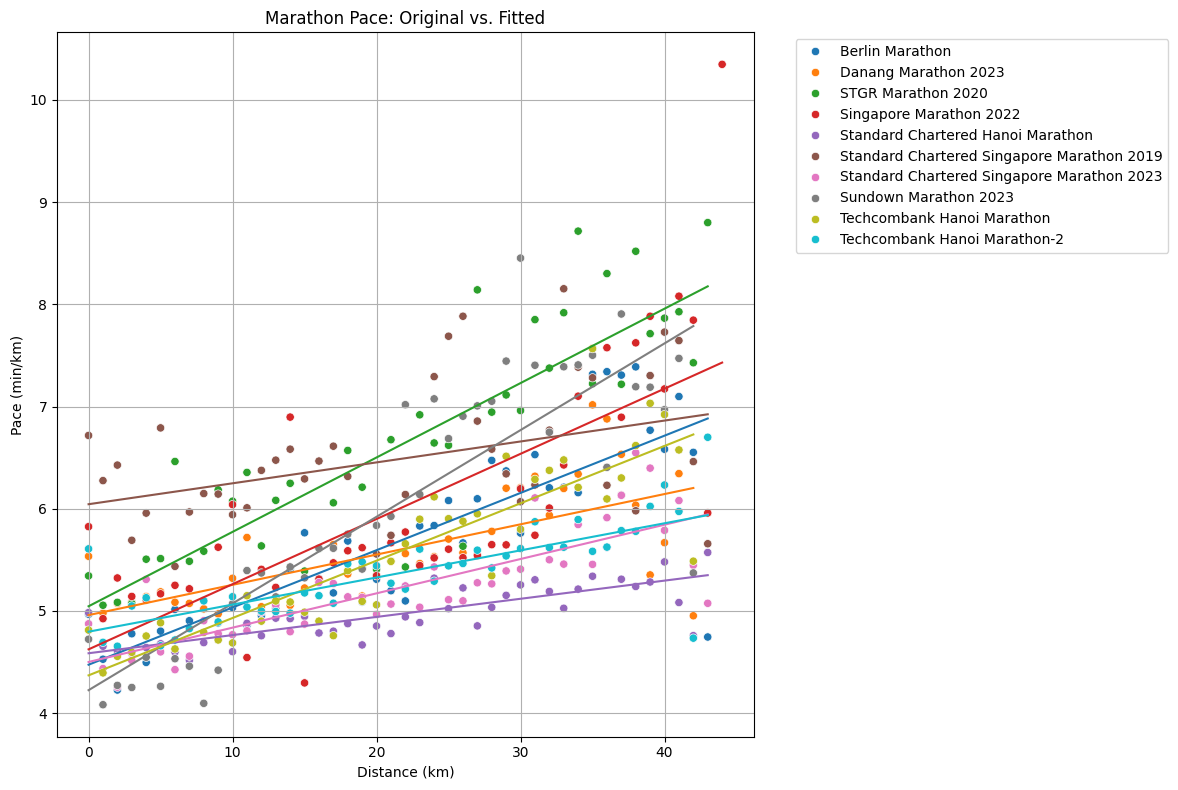

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

sns.scatterplot(data=df_combined_pace, x='Start KM', y='Average Pace (min/km)', hue='Filename')
sns.lineplot(data=df_combined_pace, x='Start KM', y='Predicted Pace', hue='Filename', legend=False)

plt.title('Marathon Pace: Original vs. Fitted')
plt.xlabel('Distance (km)')
plt.ylabel('Pace (min/km)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Add vertical line at 21km

### Subtask:
Add a vertical line at 21km to indicate the half-marathon point.


**Reasoning**:
Add a vertical line at 21km to the plot to indicate the half-marathon point.



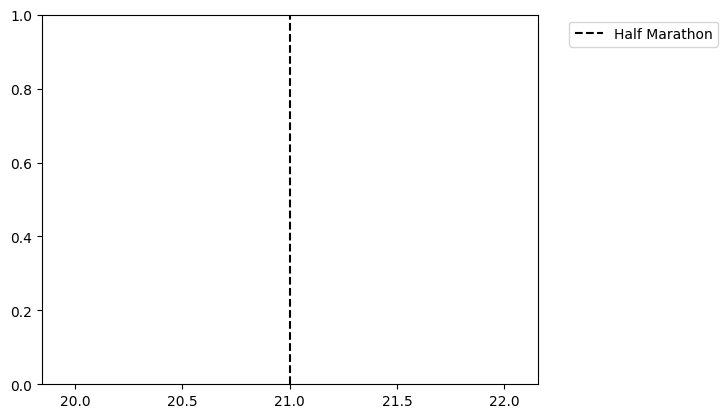

In [24]:
plt.axvline(x=21, color='k', linestyle='--', label='Half Marathon')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Customize plot

### Subtask:
Customize plot


**Reasoning**:
Add title, axis labels, legend, grid, and tight layout to the plot and display it.



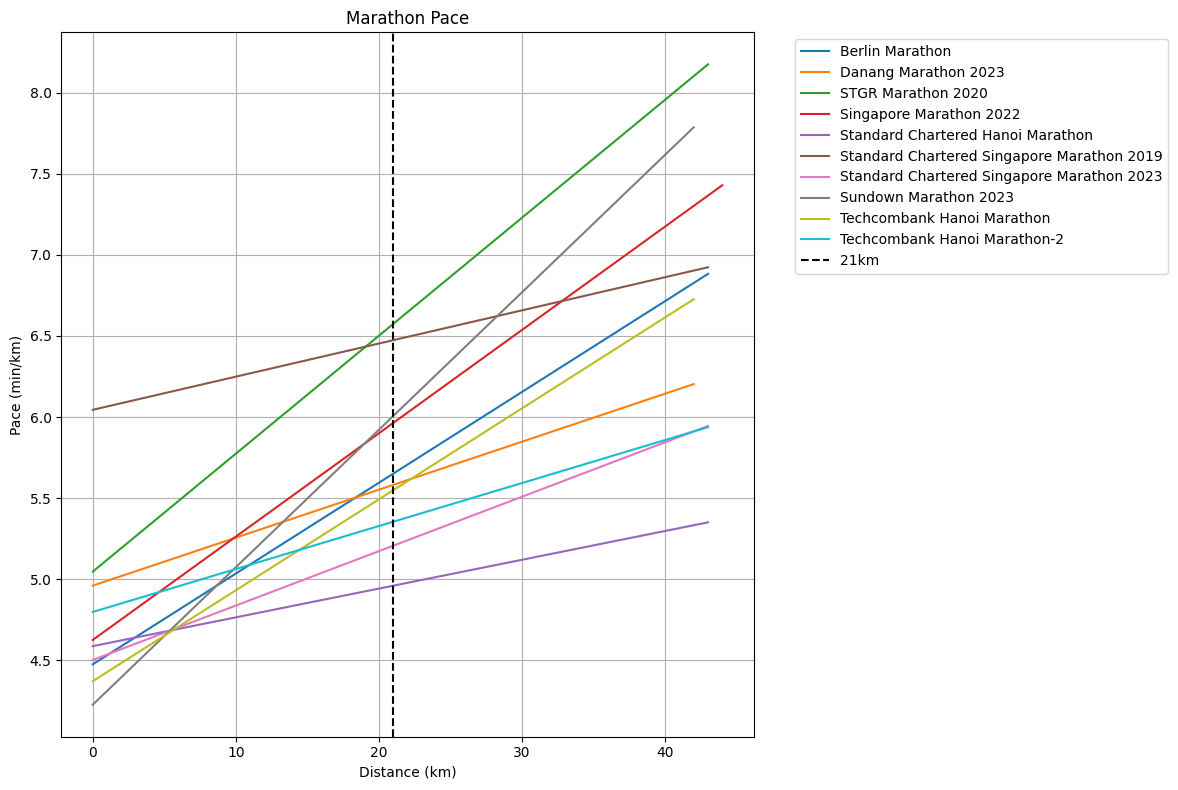

In [29]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_combined_pace, x='Start KM', y='Predicted Pace', hue='Filename')
plt.axvline(x=21, color='k', linestyle='--', label='21km')
plt.title('Marathon Pace')
plt.xlabel('Distance (km)')
plt.ylabel('Pace (min/km)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   Linear regression was successfully performed on the average pace per kilometer data for each marathon to model the relationship between distance and pace.
*   The model parameters (intercept and coefficient) for each marathon were extracted and stored, indicating the starting pace and the rate of pace change over distance.
*   Predicted pace values based on the fitted linear models were generated across the distance range for each marathon.
*   The original average pace data and the calculated fitted pace values were successfully combined into a single DataFrame for visualization.
*   A plot was generated showing the original average pace data points and the fitted linear regression lines for each marathon, allowing for a visual comparison of the model's fit.
*   A vertical dashed black line was added at the 21km mark on the plot to indicate the half-marathon point.

### Insights or Next Steps

*   Analyze the extracted linear regression coefficients (slopes) for each marathon to understand how the pace changes with distance and compare the endurance profiles of different runners or races.
*   Investigate the residuals (differences between original and fitted pace) to identify sections of the marathons where the linear model does not accurately represent the pace, potentially indicating strategic pace changes or challenging segments.
